<a href="https://colab.research.google.com/github/andrewpark19/4thyear-FYP/blob/main/ViT_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jun 22 04:26:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.5 MB/s 


In [ ]:
import cv2
import numpy as np
import pandas as pd
import albumentations as alb
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [ ]:
!unzip /content/drive/MyDrive/melanoma_data/isic_2020/train_2020/train_2020.zip > /dev/null
!unzip /content/drive/MyDrive/melanoma_data/isic_2020/test_2020/test_2020.zip > /dev/null
!unzip /content/drive/MyDrive/melanoma_data/isic_2019/train_2019/train_2019.zip > /dev/null


In [ ]:
train2020_dir = '/content/train_2020'
test2020_dir = '/content/test_2020'
train2019_dir = '/content/train_2019' 
data_dir = '/content/drive/MyDrive/melanoma_data'

def get_df(data_dir, train2020_dir, test2020_dir, train2019_dir, use_meta=False):

    ###Training Data
    #2020 Data
    df_train = pd.read_csv(os.path.join(data_dir, r'isic_2020','train_2020.csv')) #path to train_2020.csv
    df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(train2020_dir, f'{x}.jpg'))

    # #2019 data
    df_train2 = pd.read_csv(os.path.join(data_dir, r'isic_2019', 'train_2019.csv')) #path to train_2019.csv
    df_train2['filepath'] = df_train2['image_name'].apply(lambda x: os.path.join(train2019_dir, f'{x}.jpg'))

    # #Change Labels to match
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))

    df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

    # ###Test Data
    df_test = pd.read_csv(os.path.join(data_dir,r'isic_2020', 'test_2020.csv'))
    df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(test2020_dir, f'{x}.jpg'))

    if use_meta:
        df_train, df_test, meta_features, n_meta_features = get_meta_data(df_train, df_test)
    else:
        meta_features = None
        n_meta_features = 0

    diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
    df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
    mel_idx = diagnosis2idx['melanoma']

    return df_train, df_test, meta_features, n_meta_features, mel_idx
  

df_train, df_test, _, _, mel_idx = get_df(data_dir, train2020_dir, test2020_dir, train2019_dir, use_meta=False)

In [ ]:
SEED = 42

num_classes = 9
input_shape = (72, 72, 3)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
patience= 5
num_epochs = 40
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale=1/255.0
                                   )

generator = train_datagen.flow_from_dataframe(     
    dataframe=df_train,  
    directory=None,
    x_col='filepath', # name of col in data frame that contains file names
    y_col="diagnosis", # name of col with labels 
    batch_size=42997,
    shuffle=True,
    #save_to_dir=saveDir,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='sparse'
)


imgs,labels = next(generator)
print(f"imgs.shape:{imgs.shape},labels.shape:{labels.shape}")


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 15460 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 42997 validated image filenames belonging to 9 classes.
imgs.shape:(42997, 72, 72, 3),labels.shape:(42997,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(imgs,labels, test_size=0.25,stratify=labels, random_state=SEED)
print(f"X_train.shape:{X_train.shape},X_val.shape:{X_val.shape}")
print(f"y_train.shape:{y_train.shape},y_val.shape:{y_val.shape}")

X_train.shape:(32247, 72, 72, 3),X_val.shape:(10750, 72, 72, 3)
y_train.shape:(32247,),y_val.shape:(10750,)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size,**kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size

    def get_config(self):
      cfg = super().get_config()
      return cfg  

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
      cfg = super().get_config()
      return cfg  

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 patches (Patches)              (None, None, 108)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 144, 64)     128         ['patch_encoder[0][0]']          
 alization)                                                                                   

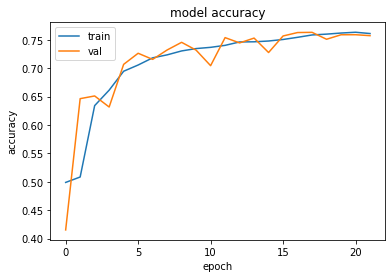

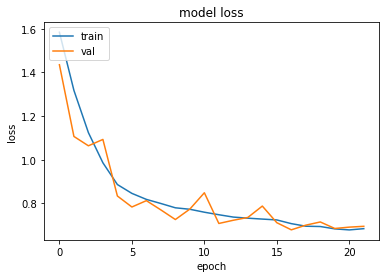

In [ ]:
from sklearn.utils import class_weight
import shutil

weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(y_train),
                                            y= y_train)
weights = dict(zip(np.unique(y_train), weights))

vit = create_vit_classifier()
vit.summary()


optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
vit.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
    ],
)
model_name = "melanoma_ViT.h5"
log_dir = os.path.join(os.getcwd(), 'logs')
filepath='ViT.{epoch:02d}-{val_loss:.4f}.h5'
ck_path = os.path.join(log_dir, filepath)
if not os.path.isdir(log_dir):
  os.makedirs(log_dir)
mc = keras.callbacks.ModelCheckpoint(ck_path, monitor='val_loss',save_best_only=True,save_weights_only=True)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=0) # when patience epoch val_loss not improve, stop train
# tb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
callbacks = [es, mc]


history = vit.fit(
    x = X_train,
    y = y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val,y_val),
    # validation_split=0.1,
    # shuffle=True,
    callbacks=callbacks,
    #class_weight = weights,
)

# To see history keys for visualization
print(history.history.keys())

vit.save('vit_multi.h5') 
shutil.copy('vit_multi.h5', '/content/drive/MyDrive/melanoma_data/models')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


ROC: 0.6679824304654136
AP score and AUC: 0.6003426717144402


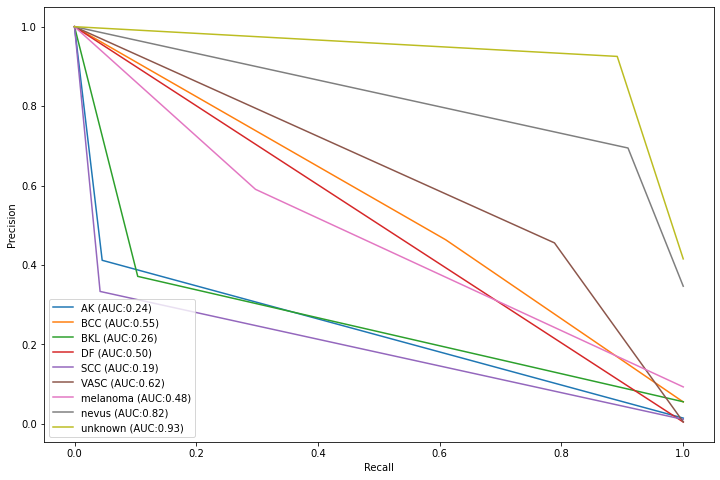

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


ypred = vit.predict(X_val)
ypred = ypred.argmax(axis=-1)

target= ['AK', 'BCC', 'BKL', 'DF', 'SCC',
          'VASC', 'melanoma', 'nevus', 'unknown']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_pr(y_test, ypred):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  ypred = lb.transform(ypred)

  for idx, c_label in enumerate(target):
    precision, recall, _  = precision_recall_curve(y_test[:,idx].astype(int), ypred[:,idx].astype(int))
    c_ax.plot(recall, precision, label = '%s (AUC:%0.2f)'  % (c_label, auc(recall, precision)))

  print('ROC:', roc_auc_score(y_val, ypred, multi_class="ovo"))
  #c_ax.plot(recall, precision, 'b-', label = 'Random Guessing')
  return average_precision_score(y_test, ypred, average='micro')


print('AP score and AUC:', multiclass_pr(y_val, ypred))

c_ax.legend()
c_ax.set_xlabel('Recall')
c_ax.set_ylabel('Precision')
plt.show()

#Predicting with the Vision Transformer


In [48]:
#Path to input tested image
from tensorflow.keras.preprocessing import image

inputfile_path = '/content/ISIC_0015719.jpg'

img = cv2.imread(inputfile_path)
img = cv2.resize(img, (72,72))
norm_img = (img - np.min(img))/np.ptp(img)

img_batch = np.expand_dims(norm_img, axis=0)

pred = vit.predict(img_batch)
pred
print('The predicted class is:', target[np.argmax(pred,axis=1)[0]])

The predicted class is: nevus
